# Example 3: Sea Surface Temperature

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pydmd import BOPDMD, SparseBOPDMD
from pydmd.sbopdmd_utils import *

def error(actual, truth):
    """
    Compute relative error.
    """
    return np.linalg.norm(actual - truth) / np.linalg.norm(truth)

import warnings
warnings.filterwarnings("ignore")

## Part 1: Import the Data
<ins>Data Website</ins>: https://www.metoffice.gov.uk/hadobs/hadisst/

Data successfully loaded!
Data dimensions in (space, time): (64800, 396)
SST Data dimensions in (space, time): (34504, 396)


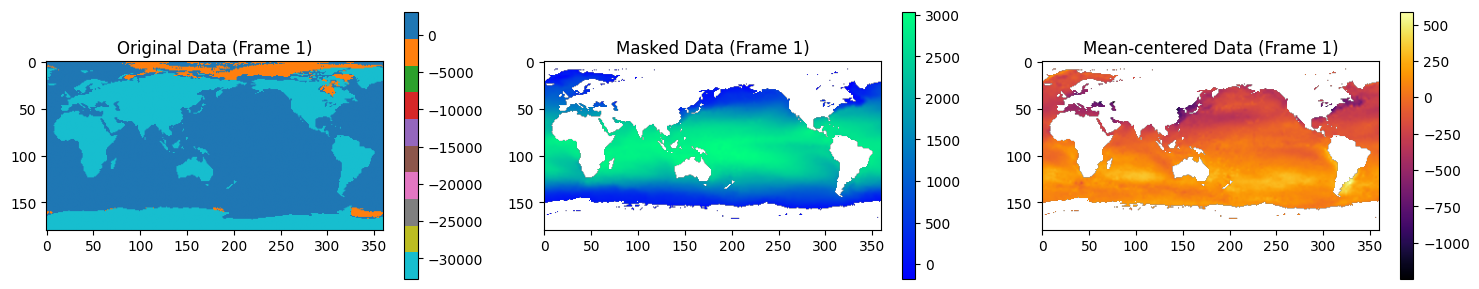

In [2]:
ny = 180  # Number of data points along the vertical axis.
nx = 360  # Number of data points along the horizontal axis.
nt = 12  # Number of temporal snapshots per file year.
land = -32768  # Value used to flag sea-ice-covered squares.
ice = -1000  # Value used to flag land squares.
shift = -155  # Choose parameter for horizontal shift.

# IMPORT DATA FROM 1991-2003 (as flattened snapshots).
filename = "data/HadISST1/HadISST1_SST_1991-2003.txt"
header_inds = np.arange(13 * nt) * (ny + 1)
data = pd.read_csv(filename, skiprows=header_inds, header=None, delim_whitespace=True)
data_mat = data.to_numpy().astype(float).reshape(13 * nt, ny, nx)
data_mat = np.roll(data_mat, shift, axis=2)
X_full_0 = data_mat.reshape(13 * nt, ny * nx).T

# IMPORT DATA FROM 2004-2023 (as flattened snapshots).
YEARS = np.arange(2004, 2024)
header_inds = np.arange(nt) * (ny + 1)
X_full = np.empty((ny * nx, len(YEARS) * nt))
# NOTE: Assumes that every data file contains a 180x360 data snapshot for
# each month of the year, where each snapshot is preceded by a header row.
for i, year in enumerate(YEARS):
    filename = f"data/HadISST1/HadISST1_SST_{year}.txt"
    data = pd.read_csv(filename, skiprows=header_inds, header=None, delim_whitespace=True)
    data_mat = data.to_numpy().astype(float).reshape(nt, ny, nx)
    data_mat = np.roll(data_mat, shift, axis=2)
    X_full[:, i*nt:(i+1)*nt] = data_mat.reshape(nt, ny * nx).T

# Concatenate the data matrices together.
X_full = np.hstack([X_full_0, X_full])
print("Data successfully loaded!")
print(f"Data dimensions in (space, time): {X_full.shape}")

# DETERMINE THE INDICES THAT ACTUALLY CONTAIN SST DATA.
# NOTE: Use all frames to determine the mask.
inds_all = np.arange(ny * nx)

# Indices of the SST data points.
inds_data = np.copy(inds_all)
for frame in X_full.T:
    inds_data_i = inds_all[np.logical_and(frame != land, frame != ice)]
    inds_data = np.intersect1d(inds_data, inds_data_i)

# Generate masked data for visualization.
inds_mask = np.setdiff1d(inds_all, inds_data)
X_masked = np.copy(X_full)
X_masked[inds_mask] = np.nan

# Generate masked, mean-centered data for visualization.
X_masked_c = np.copy(X_full)
feature_means = np.average(X_masked_c, axis=1)[:, None]
X_masked_c -= feature_means
X_masked_c[inds_mask] = np.nan

# Get the SST data for method applications.
X = X_masked_c[inds_data]
t = np.arange(X.shape[1])
mean = feature_means[inds_data]
print(f"SST Data dimensions in (space, time): {X.shape}")

# Visualize the data.
plt.figure(figsize=(15, 3))
plt.subplot(1, 3, 1)
plt.title("Original Data (Frame 1)")
plt.imshow(X_full[:, 0].reshape(ny, nx), cmap="tab10_r")
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("Masked Data (Frame 1)")
plt.imshow(X_masked[:, 0].reshape(ny, nx), cmap="winter")
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("Mean-centered Data (Frame 1)")
plt.imshow(X_masked_c[:, 0].reshape(ny, nx), cmap="inferno")
plt.colorbar()
plt.tight_layout()
plt.show()

## Part 2: Apply DMD

In [3]:
def apply_mask(x):
    """
    Re-apply data mask for plotting.
    """
    x_full = np.empty(ny * nx)
    x_full[inds_mask] = np.nan
    x_full[inds_data] = x
    return x_full

def plot_modes(
    model,
    index_modes=None,
    fig_title=None,
    fig_label=None,
    figsize=None,
    dpi=None,
    grid=None,
    vmax=None,
    scale=0.3,
    show_cbar=False,
    show_ticks=False,
):
    """
    Helper function for plotting DMD results for this particular data set.
    Given a fitted PyDMD model, plots the modes with the mask re-applied.
    """
    mode_order = np.argsort(-np.abs(model.amplitudes))
    lead_modes = model.modes[:, mode_order]

    if index_modes is None:
        index_modes = np.arange(lead_modes.shape[-1])

    if grid is None:
        grid = (1, len(index_modes))

    modes_plot = lead_modes[:, index_modes].T

    if vmax is None:
        vmax = scale * np.abs(modes_plot).max()

    fig = plt.figure(figsize=figsize, dpi=dpi)

    if fig_title is not None:
        plt.suptitle(fig_title, fontsize=18, y=0.9)

    for i, mode in enumerate(modes_plot):
        ax = fig.add_subplot(grid[0], grid[1], i + 1)

        im = ax.imshow(
            apply_mask(mode).reshape(ny, nx),
            vmax=vmax,
            vmin=-vmax,
            cmap="RdBu_r",
        )

        if show_cbar:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="3%", pad=0.05)
            fig.colorbar(im, cax=cax)

        if not show_ticks:
            ax.set_xticks([])
            ax.set_yticks([])

        if i == 0 and fig_label is not None:
            plt.ylabel(fig_label, rotation=0, labelpad=20, fontsize=15)

    plt.tight_layout()
    plt.show()

def plot_dynamics(
    model,
    num_plot=None,
    index_modes=None,
    figsize=None,
    dpi=None,
    normalize=True,
    show_legend=False,
    ylim=None,
):
    """
    Helper function for plotting DMD results for this particular data set.
    Given a fitted PyDMD model, plots the normalized time dynamics.
    """
    # We possess data from all 12 months from the year 1991--2023.
    t_actual = np.arange(1991, 2024, 1 / 12)
    x_ticks = np.arange(1991, 2024, 4)

    mode_order = np.argsort(-np.abs(model.amplitudes))
    lead_dynamics = model.dynamics[mode_order]
    lead_amps = model.amplitudes[mode_order]

    if num_plot is None:
        num_plot = lead_dynamics.shape[-1]

    if normalize:
        lead_dynamics /= lead_amps[:, None]

    if index_modes is None:
        index_modes = np.arange(len(lead_dynamics))

    plt.figure(figsize=figsize, dpi=dpi)
    for i, idx in enumerate(index_modes):
        plt.plot(
            t_actual[:num_plot],
            lead_dynamics[idx, :num_plot],
            lw=2,
            label=f"Mode {idx + 1}",
        )

    if show_legend:
        plt.legend()

    if ylim is not None:
        plt.ylim(ylim)

    plt.title("Time Dynamics ($Re(e^{\omega_i t})$)", fontsize=15)
    plt.xlabel("Year", fontsize=15)
    plt.xticks(ticks=x_ticks, labels=x_ticks.astype(str))
    plt.grid()
    plt.show()


## Optimized DMD

DMD results:
Model Error: 0.228861540009255


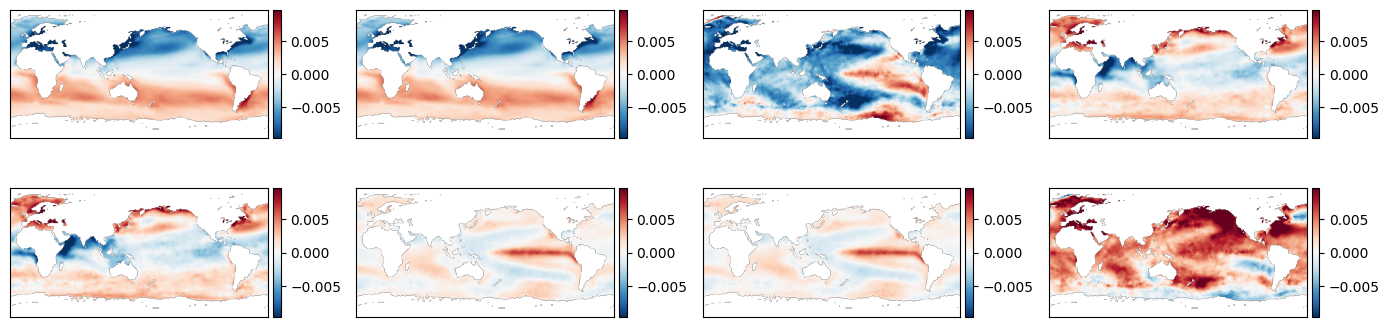

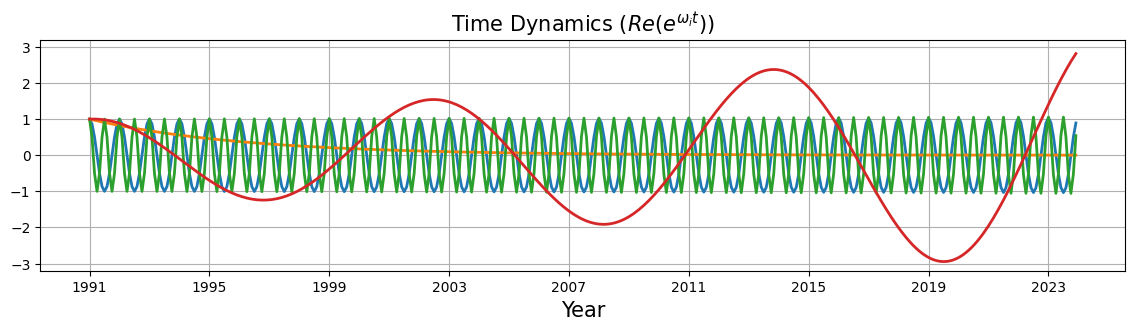

In [4]:
optdmd = BOPDMD(svd_rank=8)
optdmd.fit(X, t=t)

print("DMD results:")
print(f"Model Error: {error(optdmd.reconstructed_data, X)}")
plot_modes(optdmd, figsize=(14, 4), grid=(2, 4), show_cbar=True)
plot_dynamics(optdmd, index_modes=[0, 2, 3, 5], figsize=(14, 3), ylim=[-3.2, 3.2])

## Sparse-mode DMD (SR3)

Sparse-mode DMD (SR3) results (lambda = 2.0):
Model Error = 0.2899212322986773
66 variable projection iterations.
6.515151515151516 mode update iterations on average.


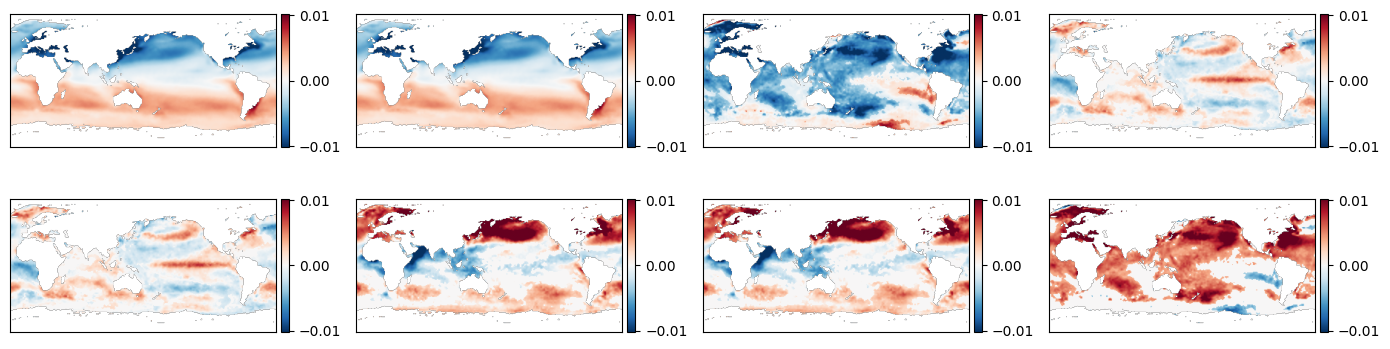

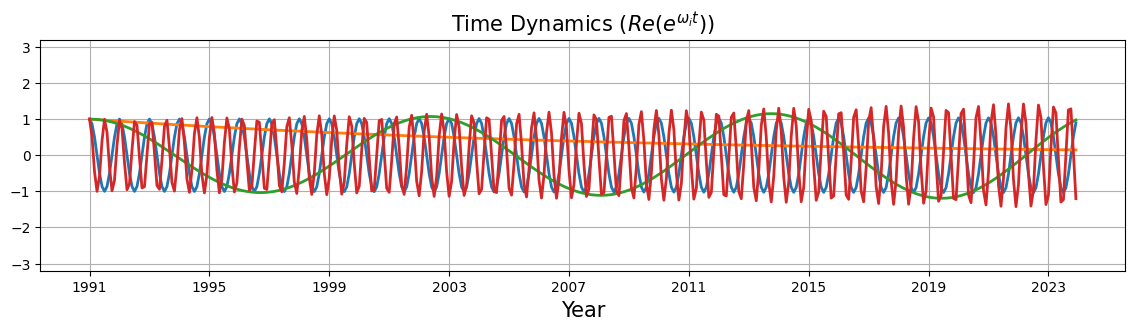

Sparse-mode DMD (SR3) results (lambda = 2.5):
Model Error = 0.29351927764595176
86 variable projection iterations.
7.0 mode update iterations on average.


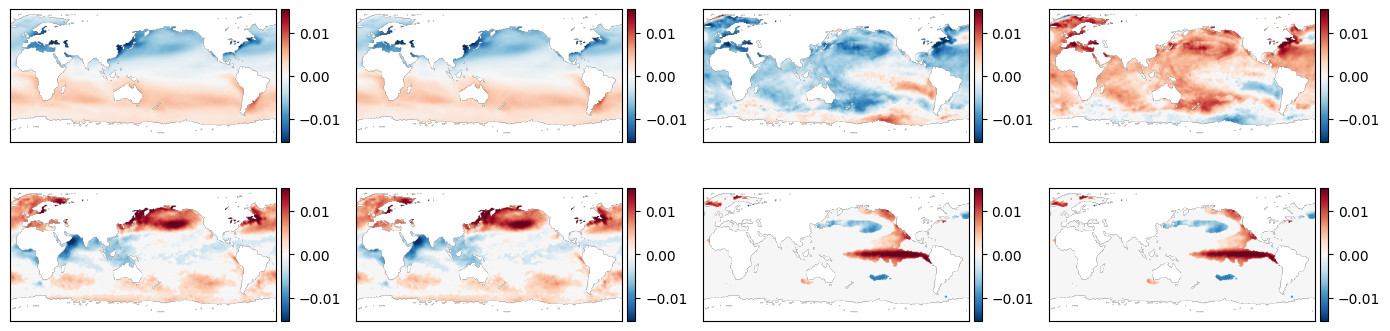

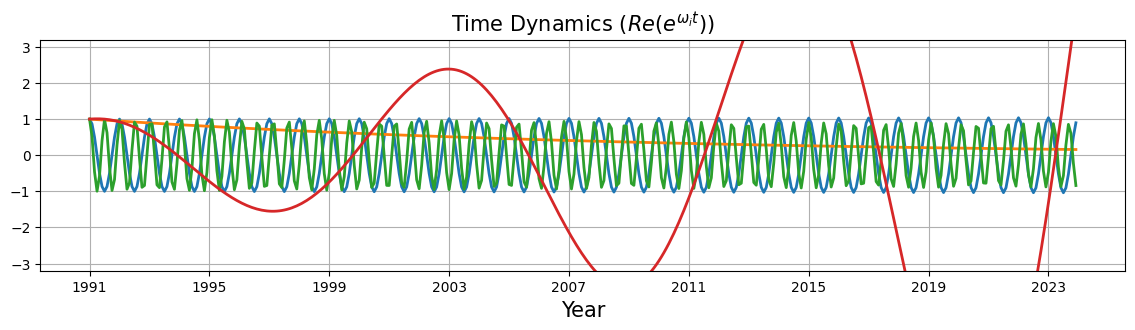

Sparse-mode DMD (SR3) results (lambda = 3.0):
Model Error = 0.29507836084917216
69 variable projection iterations.
7.0 mode update iterations on average.


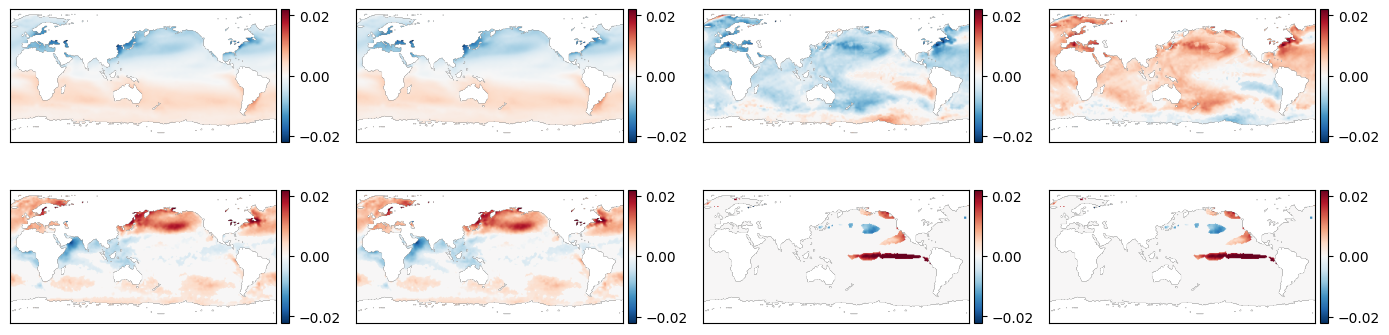

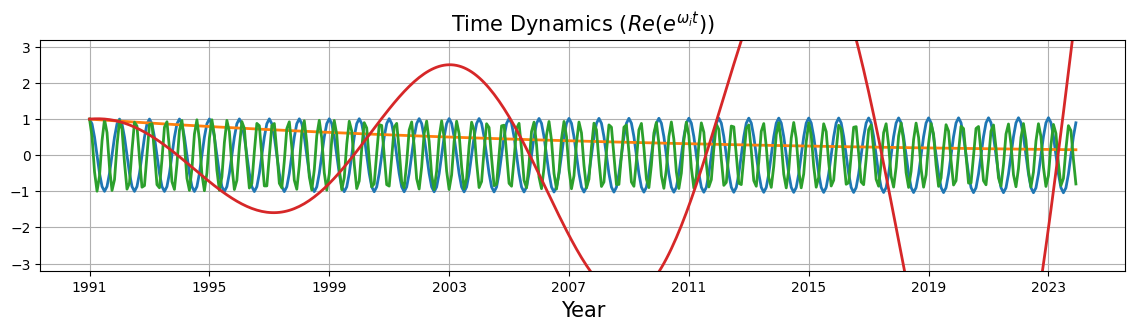

In [5]:
sr3_models = []
sr3_lambda_values = [2.0, 2.5, 3.0]
idx_lists = [[0, 2, 3, 5], [0, 2, 4, 6], [0, 2, 4, 6]]

for _lambda in sr3_lambda_values:

    sp_optdmd = SparseBOPDMD(
        svd_rank=8,
        SR3_step=1,
        mode_regularizer="l1",
        regularizer_params={"lambda": _lambda},
        apply_debias=True,
        index_global="auto",
        varpro_opts_dict={
            # "verbose": True,
            "maxiter": 100,
        },
    )
    sp_optdmd.fit(X, t=t)
    sr3_models.append(sp_optdmd)

for i, (dmd, _lambda) in enumerate(zip(sr3_models, sr3_lambda_values)):
    print(f"Sparse-mode DMD (SR3) results (lambda = {_lambda}):")
    print(f"Model Error = {error(dmd.reconstructed_data, X)}")
    print(f"{len(dmd.operator._obj_history)} variable projection iterations.")
    avg_iter = np.average([len(x) for x in dmd.operator._obj_history])
    print(f"{avg_iter} mode update iterations on average.")

    plot_modes(dmd, figsize=(14, 4), grid=(2, 4), show_cbar=True)
    plot_dynamics(dmd, index_modes=idx_lists[i], figsize=(14, 3), ylim=[-3.2, 3.2])

## Sparse-mode DMD (FISTA)

FISTA Results:


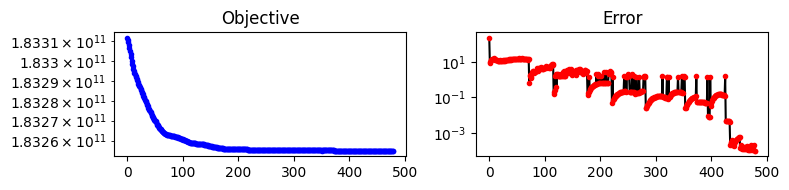

Iteration 1: Objective = 4516674.8534 Error (alpha) = 0.0068 Error (B) = 744.4229.

FISTA Results:


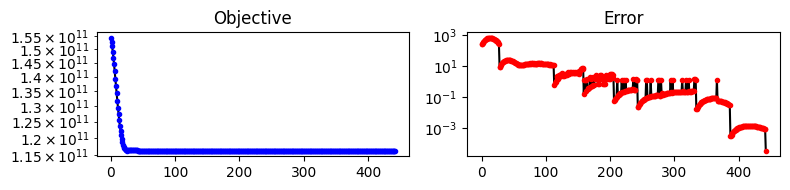

Iteration 2: Objective = 2809208.3897 Error (alpha) = 0.0023 Error (B) = 14059.8585.

FISTA Results:


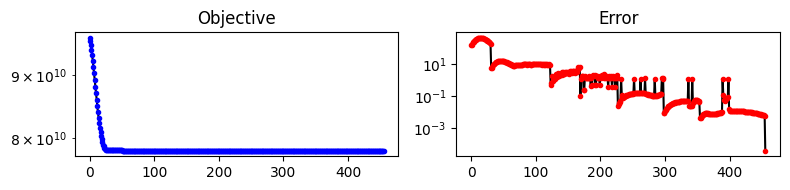

Iteration 3: Objective = 1928125.7604 Error (alpha) = 0.0017 Error (B) = 9621.0007.

Iteration 4: Objective = 1440885.759 Error (alpha) = 0.0013 Error (B) = 7012.1846.

Iteration 5: Objective = 1167288.3637 Error (alpha) = 0.0011 Error (B) = 5201.9282.

Iteration 6: Objective = 1012710.6582 Error (alpha) = 0.001 Error (B) = 3889.6814.

Iteration 7: Objective = 925091.0387 Error (alpha) = 0.0009 Error (B) = 2920.6926.

Iteration 8: Objective = 875362.0644 Error (alpha) = 0.0009 Error (B) = 2198.9184.



KeyboardInterrupt: 

In [40]:
sp_optdmd_fista = SparseBOPDMD(
    svd_rank=8,
    SR3_step=0,
    mode_regularizer="l0",
    regularizer_params={"lambda": 20000}, # 10000
    index_global="auto",
    varpro_opts_dict={
        "verbose": True,
        "maxiter": 500,
        "mode_opt_params": {"tol": 1e-4},
    },
)
sp_optdmd_fista.fit(X, t=t)

print("Sparse-mode DMD (FISTA) results:")
print(f"Model Error = {error(sp_optdmd_fista.reconstructed_data, X)}")
print(f"{len(sp_optdmd_fista.operator._obj_history)} variable projection iterations.")
avg_iter = np.average([len(x) for x in sp_optdmd_fista.operator._obj_history])
print(f"{avg_iter} mode update iterations on average.")

plot_modes(sp_optdmd_fista, figsize=(14, 4), grid=(2, 4), show_cbar=True)
plot_dynamics(sp_optdmd_fista, index_modes=[0, 2, 4, 6], figsize=(14, 3), ylim=[-3.2, 3.2])

Sparse-mode DMD (FISTA) results:
Model Error = 0.28326554092316064
105 variable projection iterations.
720.9904761904762 mode update iterations on average.


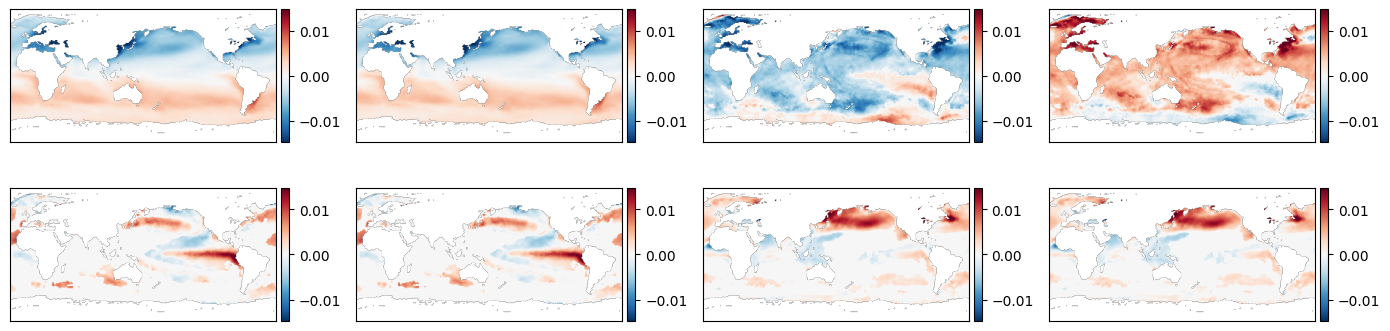

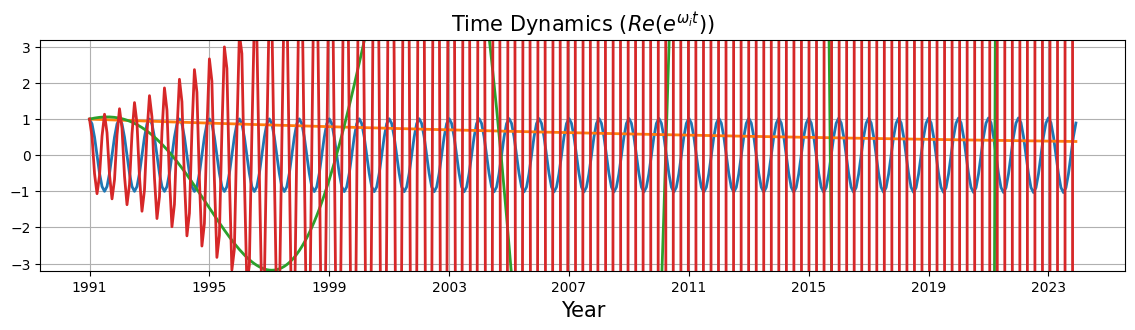

### Figures:

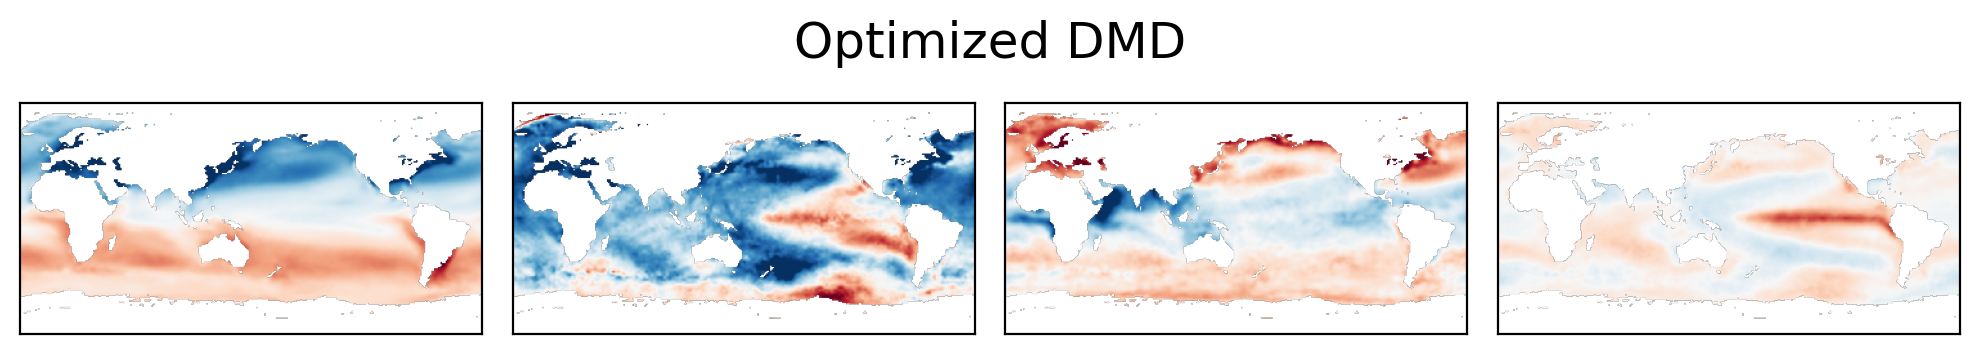

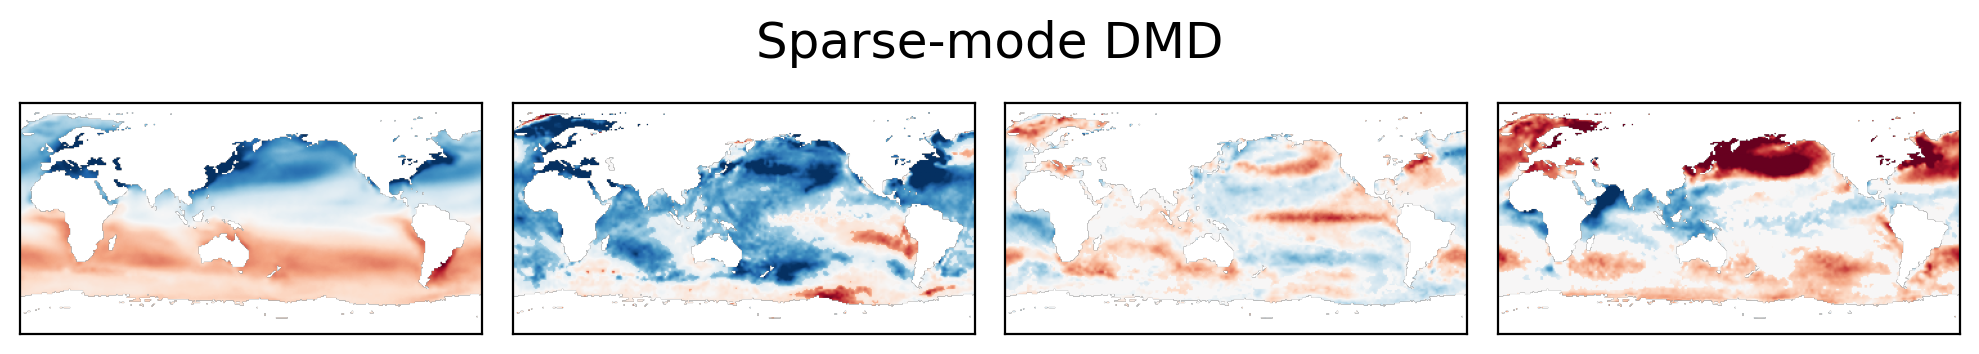

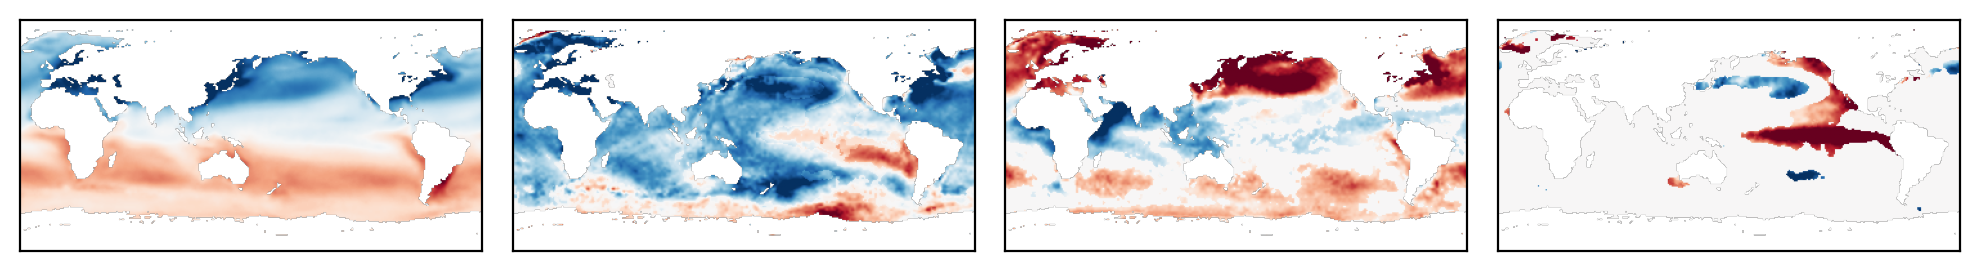

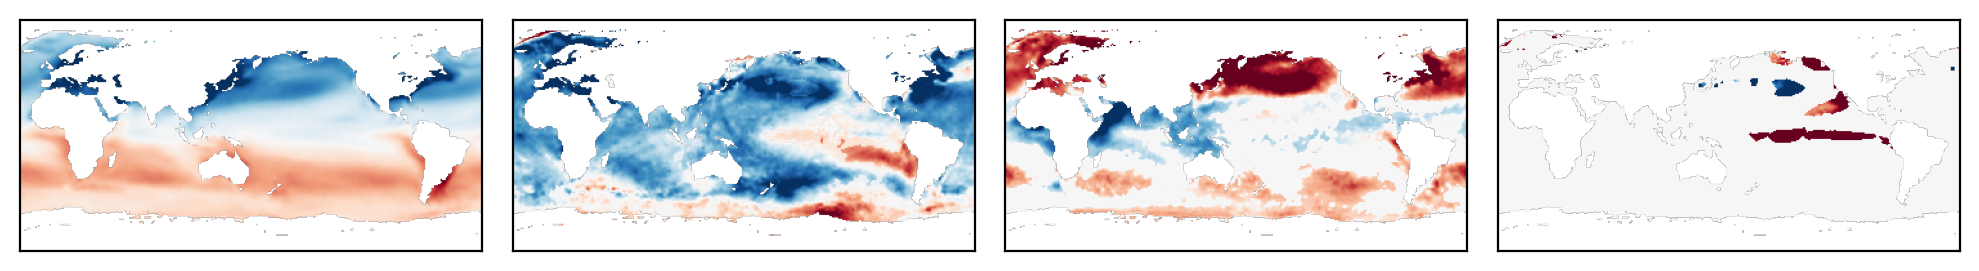

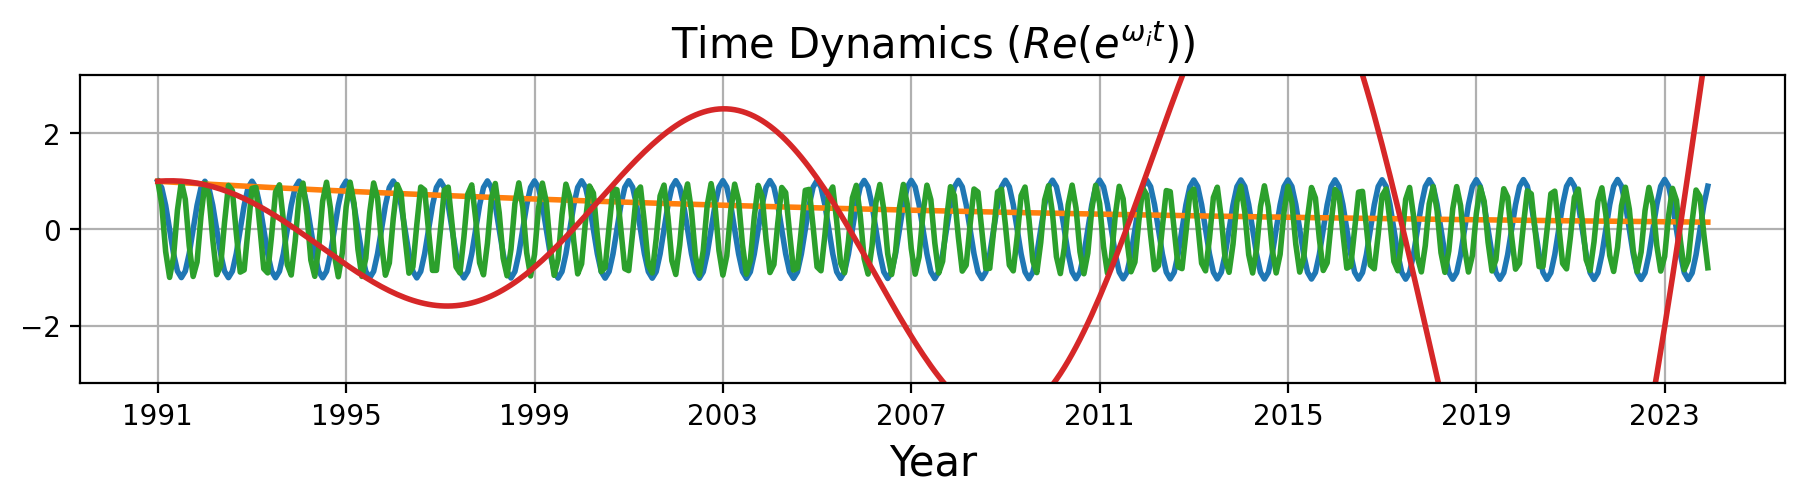

In [15]:
plot_modes(optdmd, figsize=(10, 2), grid=(1, 4), index_modes=[0, 2, 3, 5], dpi=200, vmax=0.01, fig_title="Optimized DMD")
plot_modes(sr3_models[0], figsize=(10, 2), grid=(1, 4), index_modes=idx_lists[0], dpi=200, vmax=0.01, fig_title="Sparse-mode DMD")
plot_modes(sr3_models[1], figsize=(10, 2), grid=(1, 4), index_modes=idx_lists[1], dpi=200, vmax=0.01)
plot_modes(sr3_models[2], figsize=(10, 2), grid=(1, 4), index_modes=idx_lists[2], dpi=200, vmax=0.01)
plot_dynamics(sr3_models[2], index_modes=idx_lists[2], figsize=(11, 2), ylim=[-3.2, 3.2], dpi=200)